In [1]:
import os
import random
import numpy as np
import tensorflow as tf
from keras import layers, models, optimizers, callbacks, losses
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, confusion_matrix
from scipy.signal import butter, filtfilt
import pywt

random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

SAVE_DIR = "models"
os.makedirs(SAVE_DIR, exist_ok=True)

print("環境初始化完成。")


2024-12-11 07:39:35.269028: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733902775.279629 3836497 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733902775.282810 3836497 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-11 07:39:35.293663: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


環境初始化完成。


In [2]:
DATA_DIR = "dataset"
FS = 500                       # 取樣頻率 (Hz)，請依您的資料集調整
WINDOW_SECONDS = 10            # 每個片段的長度(秒)
WINDOW_SAMPLES = FS * WINDOW_SECONDS
NUM_LEADS = 12                 # 12導程
NUM_CLASSES = 9                # 九類心律不整分類
BATCH_SIZE = 32
EPOCHS = 50
INITIAL_LR = 0.001

class_weights = {
    1: 1.85,
    2: 1.54,
    3: 2.41,
    4: 8.19,
    5: 1.00,
    6: 2.95,
    7: 2.60,
    8: 2.05,
    9: 8.39
}

print("全域參數設定完成。")


全域參數設定完成。


In [3]:
def high_pass_filter(signal, cutoff=1.0, fs=500, order=4):
    """
    使用Butterworth高通濾波器移除低頻基線漂移。
    """
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    filtered_signal = filtfilt(b, a, signal)
    return filtered_signal

def denoise_signal(signal, wavelet='db4', level=1):
    """
    使用小波轉換進行簡易降噪。
    可根據實務需求調整小波母函數與層數。
    """
    coeffs = pywt.wavedec(signal, wavelet, level=level)
    # 將最高頻率的係數（細節係數）歸零，保留較低頻資訊
    coeffs[-1] = np.zeros_like(coeffs[-1])
    denoised_signal = pywt.waverec(coeffs, wavelet)
    # 如果重建後長度稍有變化，需根據實際情況處理，這裡假設長度不變
    return denoised_signal[:len(signal)]

def normalize_signal(signal, method='minmax'):
    """
    將訊號做正規化。預設為0到1之間的min-max正規化。
    可依需求改成z-score。
    """
    if method == 'minmax':
        min_val = np.min(signal)
        max_val = np.max(signal)
        if max_val - min_val == 0:
            return signal
        return (signal - min_val) / (max_val - min_val)
    elif method == 'zscore':
        mean = np.mean(signal)
        std = np.std(signal)
        if std == 0:
            return signal
        return (signal - mean) / std
    else:
        return normalize_signal(signal, 'minmax')

print("前處理函式定義完成。")

前處理函式定義完成。


In [4]:
import pandas as pd
from scipy.io import loadmat
from keras import utils

def load_and_preprocess_data():
    # 載入標籤參考檔案
    ref_df = pd.read_csv(os.path.join(DATA_DIR, "REFERENCE.csv"))

    X_list = []
    y_list = []
    
    # 讀取每筆紀錄
    for idx, row in ref_df.iterrows():
        recording_id = row['Recording']  # 如 'A0001'
        label = row['First_label']
        
        # 若標籤為NaN或非數值，可選擇跳過或處理
        if pd.isna(label):
            continue

        mat_path = os.path.join(DATA_DIR, f"{recording_id}.mat")
        if not os.path.exists(mat_path):
            continue
        
        # 載入 .mat 檔案
        mat = loadmat(mat_path)
        # mat['ECG'] 的結構類似： [[(GenderArray, AgeArray, ECG_data (12 x N))]]
        ecg_data = mat['ECG'][0,0][2]  # 取得形狀為 (12, 7500) 的numpy array
        
        total_samples = ecg_data.shape[1]  # e.g. 7500
        if total_samples < WINDOW_SAMPLES:
            # 若資料不足一個窗口長度，您可決定跳過或補零
            # 此處示範跳過
            continue
        
        # 將ECG分割成對應WINDOW_SAMPLES長度的片段
        # 例如: 若 WINDOW_SAMPLES=5000, total_samples=7500，可取一個完整片段(0:5000)
        # 剩下2500樣本不使用(可自行定義是否要處理較短的片段)
        
        num_segments = total_samples // WINDOW_SAMPLES  # 可取得的完整片段數，這裡會是1(因為7500//5000=1)
        
        for seg_idx in range(num_segments):
            segment_start = seg_idx * WINDOW_SAMPLES
            segment_end = segment_start + WINDOW_SAMPLES
            
            segment = ecg_data[:, segment_start:segment_end]  # (12, WINDOW_SAMPLES)
            
            # 前處理：高通濾波 + 小波降噪 + 正規化
            for lead_i in range(NUM_LEADS):
                lead_signal = segment[lead_i, :]
                lead_signal = high_pass_filter(lead_signal, cutoff=1.0, fs=FS)
                lead_signal = denoise_signal(lead_signal)
                lead_signal = normalize_signal(lead_signal, method='minmax')
                segment[lead_i, :] = lead_signal
            
            # segment 現在為 (12, WINDOW_SAMPLES)，需轉成 (WINDOW_SAMPLES, 12)
            segment = segment.T  # (WINDOW_SAMPLES, 12)
            
            X_list.append(segment)
            y_list.append(label)
    
    # 將List轉為numpy陣列
    X = np.array(X_list)  # (num_samples, WINDOW_SAMPLES, NUM_LEADS)
    y = np.array(y_list)  # (num_samples,)

    # 將y轉為One-hot
    y = y - 1  # 將所有標籤值減一，使之從0開始
    y = utils.to_categorical(y, num_classes=NUM_CLASSES)

    # 分割訓練/驗證/測試集
    # 此處以7:1.5:1.5比例為例，可根據需要調整
    num_data = len(X)
    train_end = int(0.7 * num_data)
    val_end = int(0.85 * num_data)

    X_train = X[:train_end]
    y_train = y[:train_end]
    X_val = X[train_end:val_end]
    y_val = y[train_end:val_end]
    X_test = X[val_end:]
    y_test = y[val_end:]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

print("資料載入與前處理函式已更新完成。")


資料載入與前處理函式已更新完成。


In [5]:
from keras import regularizers, constraints

class EnhancedAttention(layers.Layer):
    def __init__(self, regularizer=None, constraint=None, **kwargs):
        super(EnhancedAttention, self).__init__(**kwargs)
        self.regularizer = regularizers.get(regularizer)
        self.constraint = constraints.get(constraint)

    def build(self, input_shape):
        # input_shape: (batch, timesteps, features)
        feature_dim = input_shape[-1]
        
        # Weight matrix W for transforming input
        self.W = self.add_weight(name='att_weight',
                                 shape=(feature_dim, feature_dim),
                                 initializer='glorot_uniform',
                                 regularizer=self.regularizer,
                                 constraint=self.constraint,
                                 trainable=True)
        
        # Bias for intermediate computation
        self.b = self.add_weight(name='att_bias',
                                 shape=(feature_dim,),
                                 initializer='zeros',
                                 trainable=True)
        
        # Context vector u
        self.u = self.add_weight(name='att_context',
                                 shape=(feature_dim,),
                                 initializer='glorot_uniform',
                                 regularizer=self.regularizer,
                                 constraint=self.constraint,
                                 trainable=True)
        super(EnhancedAttention, self).build(input_shape)

    def call(self, x, mask=None):
        # x: (batch, timesteps, features)
        
        # Intermediate computation: uit = tanh(x @ W + b)
        uit = tf.tanh(tf.tensordot(x, self.W, axes=[2, 0]) + self.b)  # (batch, timesteps, features)
        
        # Compute attention scores: ait = uit @ u
        ait = tf.tensordot(uit, self.u, axes=[2, 0])  # (batch, timesteps)
        
        # Apply mask (optional, for padded sequences)
        if mask is not None:
            ait += (1.0 - tf.cast(mask, tf.float32)) * -1e9  # Masking for padded timesteps
        
        # Normalize attention scores: alpha = softmax(ait)
        alpha = tf.nn.softmax(ait, axis=1)  # (batch, timesteps)
        alpha = tf.expand_dims(alpha, axis=-1)  # (batch, timesteps, 1)
        
        # Weighted sum of inputs
        context = x * alpha  # (batch, timesteps, features)
        context = tf.reduce_sum(context, axis=1)  # (batch, features)
        
        return context


In [6]:
class Attention(layers.Layer):
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        # input_shape: (batch, timesteps, features)
        self.W = self.add_weight(name='att_weight', shape=(input_shape[-1], 1),
                                 initializer='normal', trainable=True)
        self.b = self.add_weight(name='att_bias', shape=(input_shape[1],),
                                 initializer='zeros', trainable=True)
        super(Attention, self).build(input_shape)

    def call(self, x):
        # x: (batch, timesteps, features)
        e = tf.matmul(x, self.W)  # (batch, timesteps, 1)
        e = tf.squeeze(e, axis=-1) + self.b  # (batch, timesteps)
        alpha = tf.nn.softmax(e)  # (batch, timesteps)
        alpha = tf.expand_dims(alpha, axis=-1)  # (batch, timesteps, 1)
        context = x * alpha
        context = tf.reduce_sum(context, axis=1)  # (batch, features)
        return context


In [17]:
def build_model():
    input_layer = layers.Input(shape=(WINDOW_SAMPLES, NUM_LEADS))

    x = input_layer
    # CNN 卷積與池化，連續5層
    for i in range(5):
        x = layers.Conv1D(filters=32*(2**i), kernel_size=3, padding='same', activation='relu')(x)
        x = layers.MaxPooling1D(pool_size=2)(x)
        x = layers.Dropout(0.1)(x)  # 添加 Dropout 層

    # BiGRU 層，回傳完整序列以便後續 Attention 使用
    x = layers.Bidirectional(layers.GRU(100, return_sequences=True))(x)

    # Attention 層
    x = Attention()(x)

    # 最終分類層
    output = layers.Dense(NUM_CLASSES, activation='softmax')(x)

    model = models.Model(inputs=input_layer, outputs=output)
    return model


In [8]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test, batch_size=BATCH_SIZE)
    y_true_labels = np.argmax(y_test, axis=1)
    y_pred_labels = np.argmax(y_pred, axis=1)

    f1 = f1_score(y_true_labels, y_pred_labels, average='macro')
    acc = accuracy_score(y_true_labels, y_pred_labels)
    auc = roc_auc_score(y_test, y_pred, average='macro', multi_class='ovr')
    cm = confusion_matrix(y_true_labels, y_pred_labels)

    print("Test F1-score:", f1)
    print("Test Accuracy:", acc)
    print("Test AUC:", auc)
    print("Confusion Matrix:\n", cm)

In [9]:
def scheduler(epoch, lr):
    drop = 0.5
    epochs_drop = 10
    if epoch % epochs_drop == 0 and epoch > 0:
        lr = lr * drop
    return lr

In [10]:
%matplotlib inline

X_train, y_train, X_val, y_val, X_test, y_test = load_and_preprocess_data()

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (6554, 5000, 12)
y_train shape: (6554, 9)
X_val shape: (1405, 5000, 12)
y_val shape: (1405, 9)
X_test shape: (1405, 5000, 12)
y_test shape: (1405, 9)


In [18]:
model = build_model()
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 5000, 12)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 5000, 32)       │         1,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 2500, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 2500, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ (None, 2500, 64)       │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_6 (MaxPooling1D)  │ (None, 1250, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 1250, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 1250, 128)      │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_7 (MaxPooling1D)  │ (None, 625, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 625, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_8 (Conv1D)               │ (None, 625, 256)       │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_8 (MaxPooling1D)  │ (None, 312, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 312, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_9 (Conv1D)               │ (None, 312, 512)       │       393,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_9 (MaxPooling1D)  │ (None, 156, 512)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 156, 512)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 156, 200)       │       368,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_1 (Attention)         │ (None, 200)            │           356 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9)              │         1,809 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 894,949 (3.41 MB)

 Trainable params: 894,949 (3.41 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
loss_fn = losses.CategoricalCrossentropy()
opt = optimizers.Adam(learning_rate=INITIAL_LR)
model.compile(optimizer=opt, loss=loss_fn, metrics=['accuracy'])

lr_callback = callbacks.LearningRateScheduler(scheduler)
checkpoint_callback = callbacks.ModelCheckpoint(
    filepath=os.path.join(SAVE_DIR, 'best_model.keras'),
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min'
)
early_stopping_callback = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

tensorboard_callback = callbacks.TensorBoard(log_dir='./logs')
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    class_weight=class_weights,
    callbacks=[lr_callback, checkpoint_callback, early_stopping_callback]
)

2024-12-11 07:44:25.940358: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1572960000 exceeds 10% of free system memory.
2024-12-11 07:44:26.911513: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1572960000 exceeds 10% of free system memory.


Epoch 1/50
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.2581 - loss: 4.4549
Epoch 1: val_loss improved from inf to 1.88745, saving model to models/best_model.keras
205/205 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - accuracy: 0.2582 - loss: 4.4537 - val_accuracy: 0.3609 - val_loss: 1.8874 - learning_rate: 0.0010
Epoch 2/50
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.3526 - loss: 3.5462
Epoch 2: val_loss improved from 1.88745 to 1.74709, saving model to models/best_model.keras
205/205 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.3526 - loss: 3.5458 - val_accuracy: 0.4043 - val_loss: 1.7471 - learning_rate: 0.0010
Epoch 3/50
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.4345 - loss: 3.0580
Epoch 3: val_loss improved from 1.74709 to 1.54697, saving model to models/best_model.keras
205/205 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.4345 - loss: 3.0578 - val_accuracy: 0.4690 - val_loss: 1.5470 - learning_rate: 0.0010
Epoch 4/50
205/205 ━━━━━━━━━━━━━━━━━━━━ 0

In [20]:
# 訓練完成後，使用測試集進行評估
evaluate_model(model, X_test, y_test)

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
Test F1-score: 0.6453076752745458
Test Accuracy: 0.6797153024911032
Test AUC: 0.9352712300942003
Confusion Matrix:
 [[ 55   0   7   0   8   4  70  23  14]
 [  0 183   4   1  14   5   7   0   2]
 [  0   5 109   1   9   0   2   0   2]
 [  0   0   2  32   2   0   5   1   1]
 [  2  11   5   0 272   1  10   4   2]
 [  5  12   7   2  15  44  42  11   6]
 [  8   4   9   0  11   0 127   9   7]
 [  1   7   7   0   5   6  35 106   3]
 [  1   2   1   2   0   0   3   5  27]]


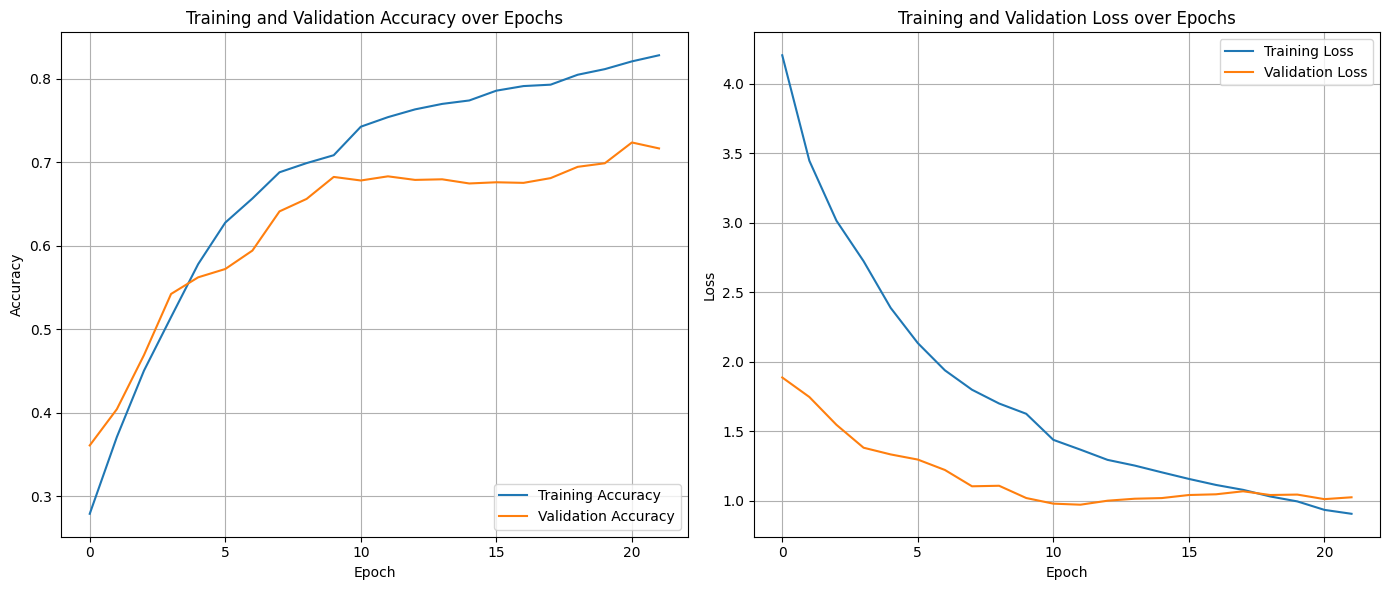

In [21]:
import matplotlib.pyplot as plt

# Ensure the history object exists
if 'history' in locals():
    # Plot accuracy
    plt.figure(figsize=(14, 6))
    
    # Plot training and validation accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.grid(True)
    
    # Plot training and validation loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
else:
    print("The history object is not found. Please ensure it is saved during model training.")


44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


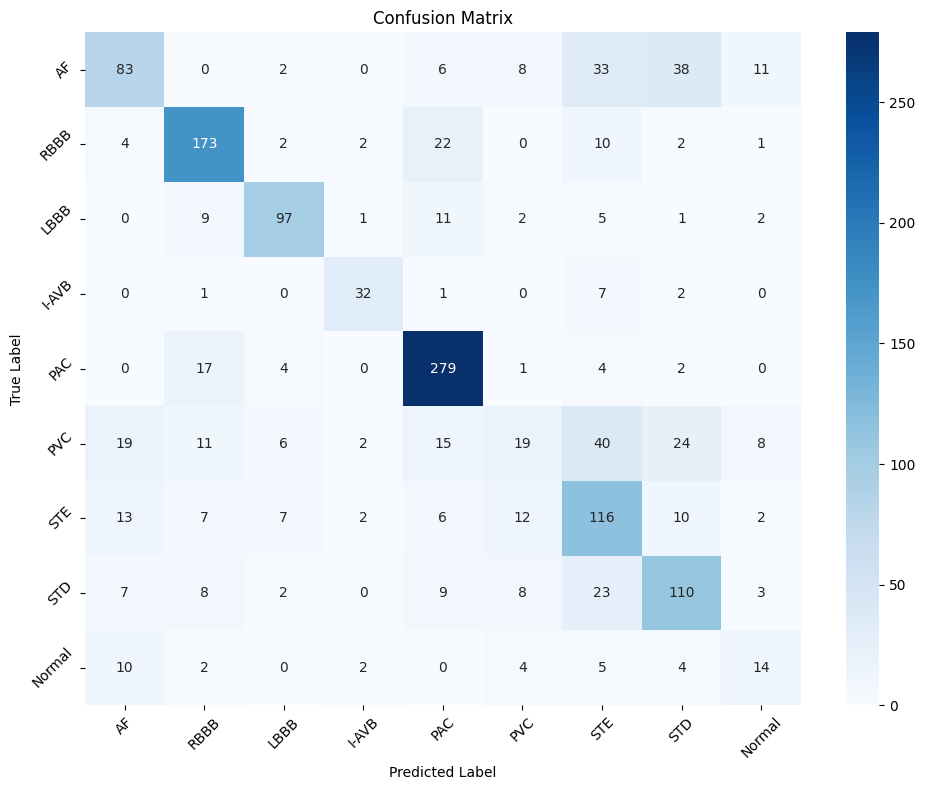

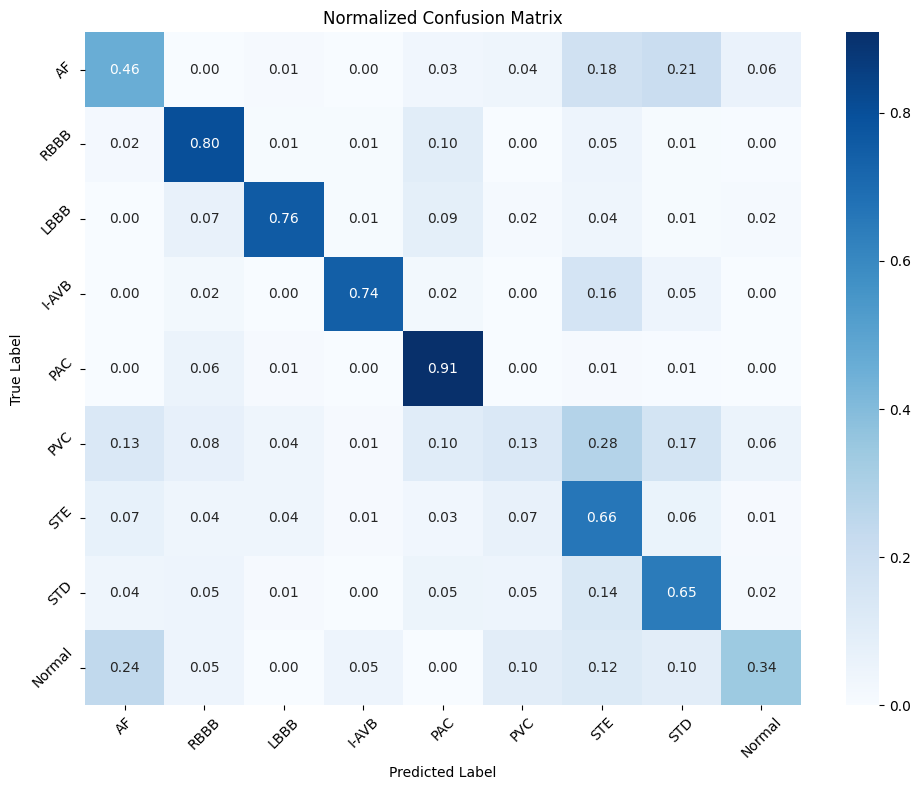

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


model.load_weights('models/best_model.keras')

# 使用模型對測試集進行預測
y_pred_prob = model.predict(X_test, batch_size=BATCH_SIZE)

# 將預測機率轉換為類別標籤 (0 到 NUM_CLASSES-1)
y_pred = np.argmax(y_pred_prob, axis=1)

# 將真實標籤從 One-hot 編碼轉換為類別標籤
y_true = np.argmax(y_test, axis=1)

# 定義類別名稱，請根據您的實際類別調整
class_names = ['AF', 'RBBB', 'LBBB', 'I-AVB', 'PAC', 'PVC', 'STE', 'STD', 'Normal']

# 計算混淆矩陣
cm = confusion_matrix(y_true, y_pred)

# Function to plot the confusion matrix
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    """
    Plot the confusion matrix.

    Parameters:
    - cm: Confusion matrix (numpy array)
    - classes: List of class names
    - normalize: Whether to normalize the confusion matrix
    - title: Title of the plot
    - cmap: Color map
    """
    if normalize:
        cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm_display = cm_normalized
        fmt = '.2f'
        label = 'Proportion (%)'
    else:
        cm_display = cm
        fmt = 'd'
        label = 'Count'

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_display, annot=True, fmt=fmt, cmap=cmap,
                xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Plot the non-normalized confusion matrix
plot_confusion_matrix(cm, classes=class_names, normalize=False, title='Confusion Matrix')

# Plot the normalized confusion matrix
plot_confusion_matrix(cm, classes=class_names, normalize=True, title='Normalized Confusion Matrix')


In [16]:
# 單導程實驗 (指引範例)
# X_train_single = X_train[:,:,[0]] # 僅取第0導程
# X_val_single = X_val[:,:,[0]]
# X_test_single = X_test[:,:,[0]]

# 您可建立與多導程類似的模型，但輸入維度為 (WINDOW_SAMPLES, 1)。
# 然後訓練此單導程模型並比較其結果。
# ensemble可將多個模型結果平均後進行評估。
